# Import libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

//## 0. Prepare Images: Review of OpenCV or What OpenCV group can do

In [2]:
#mix with OpenCV for demo
# import the images that we need in the task: load it on GitHub first

#(x_img_train,y_label_train),(x_img_test,y_label_test) = cifar10.load_data()


In [3]:
x_img_train.shape

(50000, 32, 32, 3)

In [4]:
'''
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
'''

(32, 32, 3)
32
3


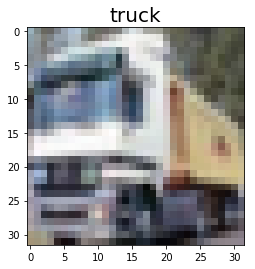

In [5]:
#see what our data looks like
'''
i = 1
pic = plt.subplot()
print(x_img_train[i].shape)
print(x_img_train[i].shape[0])
print(x_img_train[i].shape[2])
pic.imshow(x_img_train[i])
title = label_dict[y_label_train[i][0]]
pic.set_title(title,fontsize=20)
'''

In [6]:
#check for RGB
x_img_train[i][0][0]

array([154, 177, 187], dtype=uint8)

In [ ]:
#normalize, choose 3 picture: 0:2
#x_train_normalize = x_img_train[0:2][0][0].astype('float32') / 255.0

In [ ]:
#x_train_normalize[i][0][0]

In [7]:
from keras.utils import np_utils
y_label_onehot = np_utils.to_categorical(y_label_train)

## 1.1 Create placeholder: The pre-allocate dimensions for input & output
![Placeholder](https://imgur.com/lTf4ehx.png)

In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    return X, Y

In [8]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


### 1.1 Example: Placeholder + one-hot (feat. Deep Q Network, the block you will see at last)

In [ ]:
'''
# Network input
# state = 4?
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")
# action = 2 (right,left)?
# Network output
action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")
'''

## 1.2 Define the weight of CNN: filter size & channel (With initialized parameters)
- ## Filter example
![Sobel filter](https://imgur.com/YaAq4q7.png)
- ## After filter
![Human](https://imgur.com/C8XqlHm.png)
- ## Channel
![RGB](https://imgur.com/ygKlPRO.png)

In [9]:
def initialize_parameters():
    # so that your "random" numbers match ours
    tf.set_random_seed(1)                              
    
    # store weight
    # filter_width:4,filter_height:4,input_channel:3,output_channel:8
    W1 = tf.get_variable("W1", [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    # filter_width:2,filter_height:2,input_channel:8,output_channel:16
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    # make it into a dictionary of parameters
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [78]:
# have a look inside the weight
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1_first graph_channel values = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2_first graph_channel values = " + str(parameters["W2"].eval()[1,1,1]))

W1_first graph_channel values = [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2_first graph_channel values = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


** Expected Output:**

<table> 

    <tr>
        <td>
        W1_first graph_channel values = 
        </td>
        <td>
[ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394 <br>
 -0.06847463  0.05245192]
        </td>
    </tr>

    <tr>
        <td>
        W2_first graph_channel values = 
        </td>
        <td>
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058 <br>
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228 <br>
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
        </td>
    </tr>

</table>

### 1.2 Example (feat. Deep Q Network, the block you will see at last) 

In [ ]:
'''
# The variable in our network: 
w1 = tf.Variable(tf.random_normal([4,16], stddev=0.35), name="W1")
w2 = tf.Variable(tf.random_normal([16,32], stddev=0.35), name="W2")
w3 = tf.Variable(tf.random_normal([32,8], stddev=0.35), name="W3")
w4 = tf.Variable(tf.random_normal([8,2], stddev=0.35), name="W4")
b1 = tf.Variable(tf.zeros([16]), name="B1")
b2 = tf.Variable(tf.zeros([32]), name="B2")
b3 = tf.Variable(tf.zeros([8]), name="B3")
b4 = tf.Variable(tf.zeros(2), name="B4")
'''

## 1.3-1 Understanding the blocks/layers -- Learning of strides, channel, Flatten(), & Fully_Connected()

### Some definitions of functions 
(you can check on Tensorflow for other function used: https://www.tensorflow.org/api_docs/python/tf)
## Hint for 1.3-1 (<span style="color:red">Reproducing graphic concepts: CNN & Max Pool</span>)
- ### tf.nn.conv2d()
- ### tf.nn.max_pool()
- ### tf.contrib.layers.flatten()
- ### tf.contrib.layers.fully_connected()

In [10]:
def forward_propagation(X, parameters):       
    
    s = "---------------------------------------------------------------"
    print(s)
    print("Layer    Height    Width    Channel    Node   | What you will see")
    print(s)
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    
    print("Input    %d        %d        %d                | %s" % (X.shape[1],X.shape[2],X.shape[3],X.shape))
    
    #[batch, in_height, in_width, in_channels],[filter_height, filter_width, in_channels, out_channels],[1, stride, stride, 1]
    # Conv
    s1_h = 2
    s1_w = 2
    Z1 = tf.nn.conv2d(X,W1, strides = [1,s1_h,s1_w,1], padding = 'SAME')
    print("Conv     "+str(Z1.shape[1])+"        "+str(Z1.shape[2])+"        "+str(Z1.shape[3])+"                | "+str(Z1.shape))
    # ReLU
    #A1 = tf.nn.relu(Z1)
    # Max Pool
    sp1_h = 4
    sp1_w = 4
    P1 = tf.nn.max_pool(Z1, ksize = [1,sp1_h,sp1_w,1], strides = [1,sp1_h,sp1_w,1], padding = 'SAME')
    print("Max Pool  %d         %d        %d                | %s" %(P1.shape[1],P1.shape[2],P1.shape[3],P1.shape))
    # Flatten
    F1 = tf.contrib.layers.flatten(P1)
    #print("Flatten",F1.shape[1],F1.shape)
    print("Flatten                                %d    | %s" %(F1.shape[1],F1.shape))
    # Fully Connected
    Y1 = tf.contrib.layers.fully_connected(F1, num_outputs=6,activation_fn=None)
    print("Fully Connected                          %d    | %s" %(Y1.shape[1],Y1.shape))
    
    print(s)
    print("Conv_process(Between Layer: Input & Conv)")
    print("|__ Filter shape: "+str(W1.shape))
    print("|__ Stride_height: %d, Stride_width: %d" %(s1_h,s1_w))
    print("|__ How it works: See CNN operation below")
    
    print("\nPool_process(Between Layer: Conv & Max Pool)")
    print("|__ Filter_height: %d, Filter_width: %d" %(sp1_h,sp1_w))
    print("|__ Stride_height: %d, Stride_width: %d" %(sp1_h,sp1_w))
    print("|__ How it works: See Max Pooling operation below")
    
    print("\nFlatten_process(Between Layer: Max Pool & Flatten)")
    print("|__ Flatten_input: (%d,%d,%d)" %(P1.shape[1],P1.shape[2],P1.shape[3]))
    print("|__ Flatten_output: %d*%d*%d = %d" %(P1.shape[1],P1.shape[2],P1.shape[3],P1.shape[1]*P1.shape[2]*P1.shape[3]))
    return Y1

In [11]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    
    # create_placeholders(H,W,C,Output): the function you defined
    X,Y = create_placeholders(32,32,3,10)
    parameters = initialize_parameters()

    Z = forward_propagation(X,parameters)

    init = tf.global_variables_initializer()
    sess.run(init)

---------------------------------------------------------------
Layer    Height    Width    Channel    Node   | What you will see
---------------------------------------------------------------
Input    32        32        3                | (?, 32, 32, 3)
Conv     16        16        8                | (?, 16, 16, 8)
Max Pool  4         4        8                | (?, 4, 4, 8)
Flatten                                128    | (?, 128)
Fully Connected                          6    | (?, 6)
---------------------------------------------------------------
Conv_process(Between Layer: Input & Conv)
|__ Filter shape: (4, 4, 3, 8)
|__ Stride_height: 2, Stride_width: 2

Pool_process(Between Layer: Conv & Max Pool)
|__ Filter_height: 4, Filter_width: 4
|__ Stride_height: 4, Stride_width: 4

Flatten_process(Between Layer: Max Pool & Flatten)
|__ Flatten_input: (4,4,8)
|__ Flatten_output: 4*4*8 = 128


### CNN operation
![CNN](https://imgur.com/FIy5Ou4.gif)
### Max Pooling operation (Vote for the largest number)
![Max Pool](https://imgur.com/ec0zNkC.png)

In [3]:
# model.summary(pretrained_YOLO)
#from keras.models import load_model
# H5 file is created by yad2k.py
# some problems in .cfg .weight -> .h5
# yolo_model = load_model("yolov3.")

In [ ]:
#yolo_model.summary()

## 1.3-1 Example*2

### Ex.1 Placeholder + one-hot + define variable + NN + Activation function

In [ ]:
# network placeholder: input
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")
# network placeholder: output, final result with probability
action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")

# The variable in our network: 
w1 = tf.Variable(tf.random_normal([4,16], stddev=0.35), name="W1")
w2 = tf.Variable(tf.random_normal([16,32], stddev=0.35), name="W2")
w3 = tf.Variable(tf.random_normal([32,8], stddev=0.35), name="W3")
w4 = tf.Variable(tf.random_normal([8,2], stddev=0.35), name="W4")
b1 = tf.Variable(tf.zeros([16]), name="B1")
b2 = tf.Variable(tf.zeros([32]), name="B2")
b3 = tf.Variable(tf.zeros([8]), name="B3")
b4 = tf.Variable(tf.zeros(2), name="B4")

# The network layout
layer1 = tf.nn.relu(tf.add(tf.matmul(networkstate,w1), b1), name="Result1")
layer2 = tf.nn.relu(tf.add(tf.matmul(layer1,w2), b2), name="Result2")
layer3 = tf.nn.relu(tf.add(tf.matmul(layer2,w3), b3), name="Result3")
predictedreward = tf.add(tf.matmul(layer3,w4), b4, name="predictedReward")

### Ex.2 CNN + Max Pooling + Flatten + Fully Connected 

In [ ]:
def your_forward_prop(X,parameters):
    # your input data size
    print("Input: %s" % X.shape)
    tf.set_random_seed(1)
    
    # your first conv layer
    # your conv filter
    w1_h = 
    w1_w = 
    in_channel = 
    out_channel = 
    W1 = tf.get_variable("W1", [w1_h,w1_w,in_channel,out_channel], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    # your conv stride
    s1_h = 
    s1_w = 
    Z1 = tf.nn.con2d(X,W1, strides=[1,s1_h,s1_w,1], padding='SAME')
    # what you define
    print("Conv: %s" % Z1.shape)
    print("|__ Filter_height: %d, Filter_weight: %d" %(w1_h,w1_w))
    
    # your first max_pooling layer
    

** Expected Output: Not Yet**

<table> 

    <tr>
        <td>
        W1_first graph_channel values = 
        </td>
        <td>
[ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394 <br>
 -0.06847463  0.05245192]
        </td>
    </tr>

    <tr>
        <td>
        W2_first graph_channel values = 
        </td>
        <td>
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058 <br>
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228 <br>
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
        </td>
    </tr>

</table>

## 1.3-3 (Advance) More techniques on model structure -- ResNet (Reduce the back-prop), Concatence, Split

## 1.3-4 (In other tensorflow materials) Save it into log file, present on tensorboard 

//## 1.4 How similar the prediction is -- Compute cost

//## 1.5 Define the training model: Minibatch

## 1.6 More on mathematic of gradient descent (Try to do it simple, learning_rate*slope) -- Cost, Optimization, Learning rate
- ## 1) Cost function: (formula...)
![Optimization](https://imgur.com/LXBjfLb.png)
- ## 2) Learning rate
![Learning rate](https://imgur.com/J8U8fu9.jpg)

## 1.6-1 Cost function的意義:  Model "預測"結果 和 資料"實際"值 的誤差曲線(補cost圖?)
- ### Concept: cost越小 -> 預測和實際差異越小 -> 越接近真實特徵
- #### Problem: 資料實際樣本太狹隘時，又學到很精 -> 只學到這個群體的特質，不夠 general : 這個結果稱之為 overfit
1) 二次函數
2) saddle point
3) 六次函數

In [5]:
coefficients = np.array([[1.],[-10.],[25.]])
w = tf.Variable(0,dtype=tf.float32)
x = tf.placeholder(tf.float32,[3,1])

# cost = tf.add(tf.add(w**2,tf.multiply(-10.,w),25))
# operator overloading
# placeholder x, input
cost = x[0]*w**2 + x[1]*w + x[2]
#[1,2]
#[2,4,1]
#cost = x[0]*w**4 + x[1]*w**3 + x[2]*w**2
#[5,8,3,1]
#cost = x[0]*w**6+ x[1]*w**5+ x[2]*w**2+ x[3]*w
# broadcasting
#cost = w*x # (1*3)*(3*1)

## 1.6-2 Tune the learning rate

In [46]:
# play for the value between: 0.9 ~ 0.01
learning_rate = 0.7
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
#first way
'''
session = tf.Session()
session.run(init)
print(session.run(w))
'''
print("--------------------------------------------")
print("lr=%f\tweight\t\tvalue update" %learning_rate)
print("--------------------------------------------")
#second way
with tf.Session() as session:
    # initialize
    session.run(init)
    print("Initialize:\t%f" %session.run(w))
    wf = session.run(w)
    #session.run(train,feed_dict={x:coefficients})
    #print(session.run(w))
    for i in range(500):
        # put input inside
        session.run(train,feed_dict={x:coefficients})
        # print the weight & 差異, think about the curve & the lowest point
        print("Epoch %d:\t%f\t%f" %(i+1,session.run(w),session.run(w)-wf))
        wf = session.run(w)

--------------------------------------------
lr=0.700000	weight		value update
--------------------------------------------
Initialize:	0.000000
Epoch 1:	7.000000	7.000000
Epoch 2:	4.200000	-2.800000
Epoch 3:	5.320000	1.120000
Epoch 4:	4.872000	-0.448000
Epoch 5:	5.051200	0.179200
Epoch 6:	4.979520	-0.071680
Epoch 7:	5.008192	0.028672
Epoch 8:	4.996723	-0.011469
Epoch 9:	5.001311	0.004588
Epoch 10:	4.999475	-0.001835
Epoch 11:	5.000210	0.000734
Epoch 12:	4.999916	-0.000294
Epoch 13:	5.000033	0.000117
Epoch 14:	4.999987	-0.000047
Epoch 15:	5.000005	0.000019
Epoch 16:	4.999998	-0.000007
Epoch 17:	5.000001	0.000003
Epoch 18:	5.000000	-0.000001
Epoch 19:	5.000000	0.000000
Epoch 20:	5.000000	0.000000
Epoch 21:	5.000000	0.000000
Epoch 22:	5.000000	0.000000
Epoch 23:	5.000000	0.000000
Epoch 24:	5.000000	0.000000
Epoch 25:	5.000000	0.000000
Epoch 26:	5.000000	0.000000
Epoch 27:	5.000000	0.000000
Epoch 28:	5.000000	0.000000
Epoch 29:	5.000000	0.000000
Epoch 30:	5.000000	0.000000
Epoch 31:	5.0000

Epoch 425:	5.000000	0.000000
Epoch 426:	5.000000	0.000000
Epoch 427:	5.000000	0.000000
Epoch 428:	5.000000	0.000000
Epoch 429:	5.000000	0.000000
Epoch 430:	5.000000	0.000000
Epoch 431:	5.000000	0.000000
Epoch 432:	5.000000	0.000000
Epoch 433:	5.000000	0.000000
Epoch 434:	5.000000	0.000000
Epoch 435:	5.000000	0.000000
Epoch 436:	5.000000	0.000000
Epoch 437:	5.000000	0.000000
Epoch 438:	5.000000	0.000000
Epoch 439:	5.000000	0.000000
Epoch 440:	5.000000	0.000000
Epoch 441:	5.000000	0.000000
Epoch 442:	5.000000	0.000000
Epoch 443:	5.000000	0.000000
Epoch 444:	5.000000	0.000000
Epoch 445:	5.000000	0.000000
Epoch 446:	5.000000	0.000000
Epoch 447:	5.000000	0.000000
Epoch 448:	5.000000	0.000000
Epoch 449:	5.000000	0.000000
Epoch 450:	5.000000	0.000000
Epoch 451:	5.000000	0.000000
Epoch 452:	5.000000	0.000000
Epoch 453:	5.000000	0.000000
Epoch 454:	5.000000	0.000000
Epoch 455:	5.000000	0.000000
Epoch 456:	5.000000	0.000000
Epoch 457:	5.000000	0.000000
Epoch 458:	5.000000	0.000000
Epoch 459:	5.0

## 1.6-3 Example  (feat. Deep Q Network)

In [ ]:
'''
# Learning 
qreward = tf.reduce_sum(tf.multiply(predictedreward, action_onehot), reduction_indices = 1)
loss = tf.reduce_mean(tf.square(networkreward - qreward))
tf.summary.scalar('loss', loss)
optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(loss)
# summary
merged_summary = tf.summary.merge_all()
'''

## 1.7 Mix up Examples 1.3-1, 1.3-4, 1.6-2: Deep Q Network

In [ ]:
# Network input
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")
action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")

# The variable in our network: 
w1 = tf.Variable(tf.random_normal([4,16], stddev=0.35), name="W1")
w2 = tf.Variable(tf.random_normal([16,32], stddev=0.35), name="W2")
w3 = tf.Variable(tf.random_normal([32,8], stddev=0.35), name="W3")
w4 = tf.Variable(tf.random_normal([8,2], stddev=0.35), name="W4")
b1 = tf.Variable(tf.zeros([16]), name="B1")
b2 = tf.Variable(tf.zeros([32]), name="B2")
b3 = tf.Variable(tf.zeros([8]), name="B3")
b4 = tf.Variable(tf.zeros(2), name="B4")

# The network layout
layer1 = tf.nn.relu(tf.add(tf.matmul(networkstate,w1), b1), name="Result1")
layer2 = tf.nn.relu(tf.add(tf.matmul(layer1,w2), b2), name="Result2")
layer3 = tf.nn.relu(tf.add(tf.matmul(layer2,w3), b3), name="Result3")
predictedreward = tf.add(tf.matmul(layer3,w4), b4, name="predictedReward")

# Learning 
qreward = tf.reduce_sum(tf.multiply(predictedreward, action_onehot), reduction_indices = 1)
loss = tf.reduce_mean(tf.square(networkreward - qreward))
tf.summary.scalar('loss', loss)
optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(loss)

# summary
merged_summary = tf.summary.merge_all()